In [21]:
from leven import levenshtein
import numpy as np
import mxnet as mx
import random
random.seed(123)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform as skimage_tf
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection, box_nms

from utils.iam_dataset import IAMDataset, resize_image, crop_image
from utils.expand_bounding_box import expand_bounding_box

from paragraph_segmentation_dcnn import make_cnn as ParagraphSegmentationNet
from line_segmentation import SSD as LineSegmentationNet
from word_segmentation import SSD as WordSegmentationNet
from handwriting_line_recognition import Network as HandwritingRecognitionNet
from handwriting_line_recognition import decode as decoder_handwriting

In [2]:
ctx = mx.gpu(0)

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results.

In [3]:
test_ds = IAMDataset("form_original", train=False)

In [4]:
figs_to_plot = 4
images = []

for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)

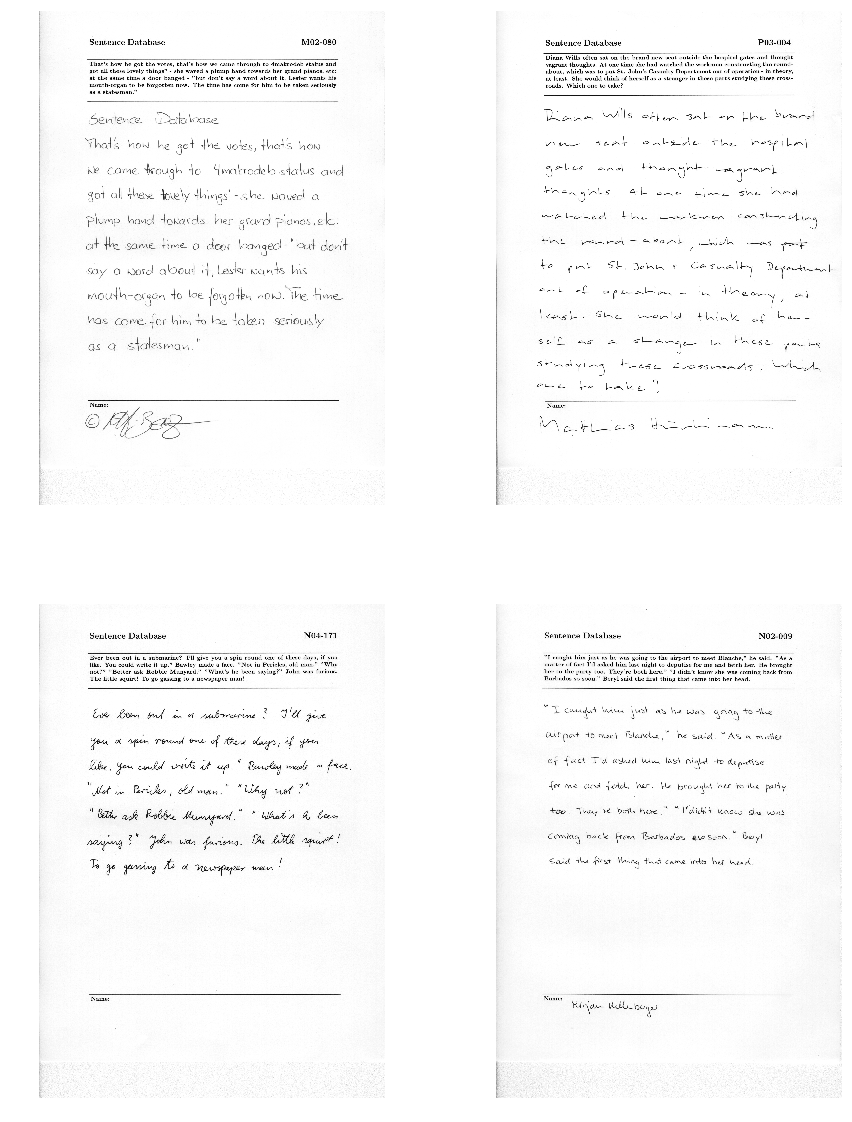

In [5]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

## Paragraph segmentation
Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component. The model was trained on using https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.py and an example is presented in https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.ipynb

In [6]:
paragraph_segmentation_net = ParagraphSegmentationNet()
paragraph_segmentation_net.load_parameters("models/paragraph_segmentation.params")

In [7]:
def paragraph_segmentation_transform(image, image_size):
    resized_image, _ = resize_image(image, image_size)
    
    resized_image = mx.nd.array(resized_image).expand_dims(axis=2)
    resized_image = mx.image.resize_short(resized_image, int(800/3))
    resized_image = resized_image.transpose([2, 0, 1])/255.

    resized_image = resized_image.as_in_context(ctx)
    resized_image = resized_image.expand_dims(axis=0)
    return resized_image

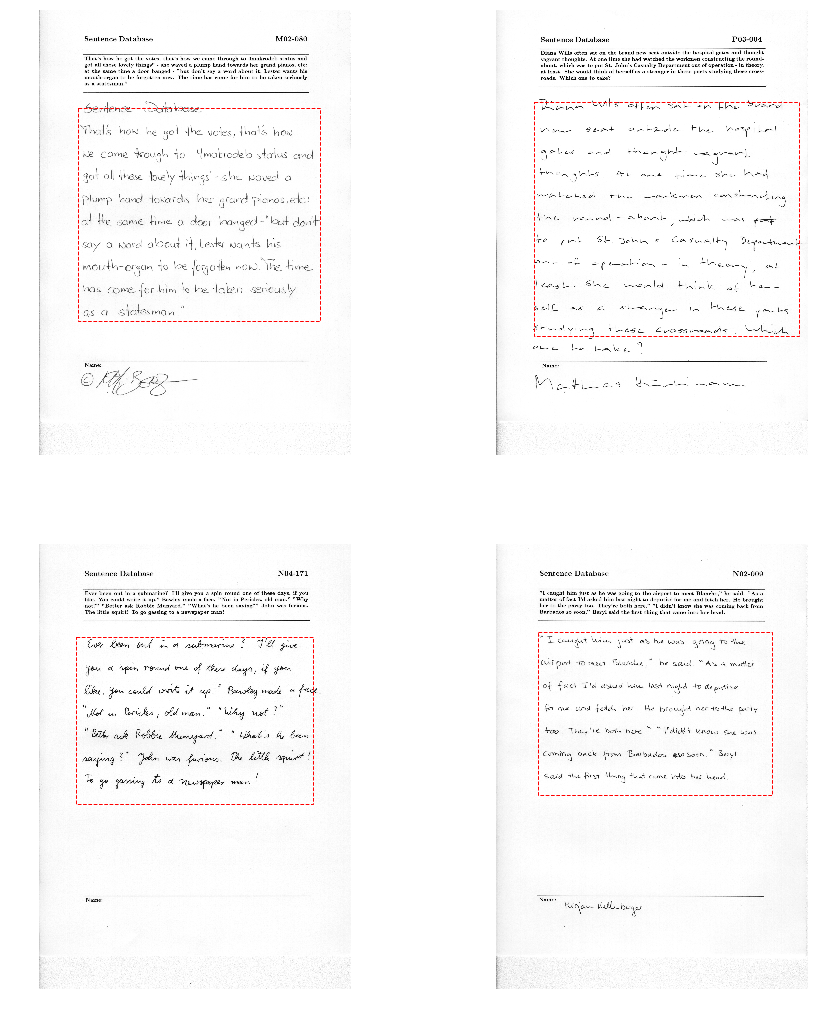

In [8]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image)
    
    bb_predicted = bb_predicted[0].asnumpy()

    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

#### Image processing
Crop the handwriting component out of the original IAM form.

In [9]:
def crop_handwriting_page(image, bb, image_size):
    expanded_bb = expand_bounding_box(bb)
    image = crop_image(image, expanded_bb)

    image, _ = resize_image(image, desired_size=image_size)
    return image

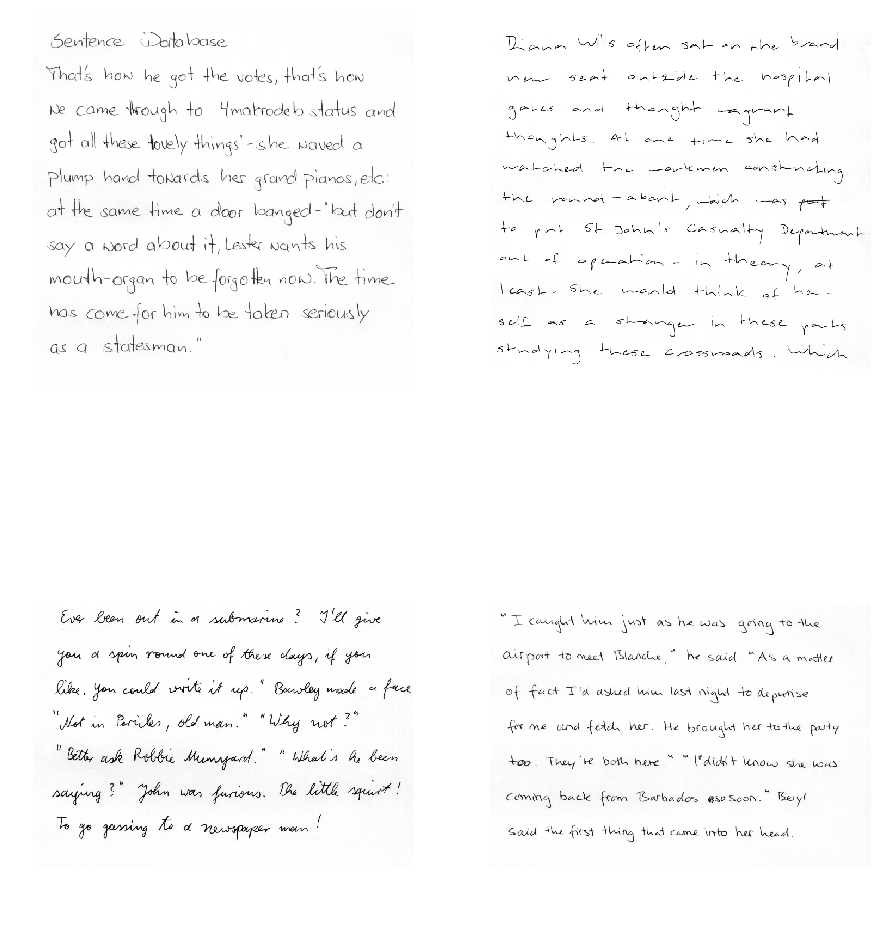

In [10]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

## Line/word segmentation
Given a form with only handwritten text, predict a bounding box for each word. The model was trained with *LINK TO WORD SEGMENTATION*

In [11]:
def predict_bounding_boxes(net, image, min_c, overlap_thres, topk):
    '''
    Given the outputs of the dataset (image and bounding box) and the network, 
    the predicted bounding boxes are provided.
    
    Parameters
    ----------
    net: SSD
    The trained SSD network.
    
    image: np.array
    A grayscale image of the handwriting passages.
        
    Returns
    -------
    predicted_bb: [(x, y, w, h)]
    The predicted bounding boxes.
    '''
    image = mx.nd.array(image).expand_dims(axis=2)
    image = mx.image.resize_short(image, 350)
    image = image.transpose([2, 0, 1])/255.

    image = image.as_in_context(ctx)
    image = image.expand_dims(0)
    
    bb = np.zeros(shape=(13, 5))
    bb = mx.nd.array(bb)
    bb = bb.as_in_context(ctx)
    bb = bb.expand_dims(axis=0)

    default_anchors, class_predictions, box_predictions = net(image)
           
    box_target, box_mask, cls_target = net.training_targets(default_anchors, 
                                                            class_predictions, bb)

    cls_probs = mx.nd.SoftmaxActivation(mx.nd.transpose(class_predictions, (0, 2, 1)), mode='channel')

    predicted_bb = MultiBoxDetection(*[cls_probs, box_predictions, default_anchors], force_suppress=True, clip=False)
    predicted_bb = box_nms(predicted_bb, overlap_thresh=overlap_thres, valid_thresh=min_c, topk=topk)
    predicted_bb = predicted_bb.asnumpy()
    predicted_bb = predicted_bb[0, predicted_bb[0, :, 0] != -1]
    predicted_bb = predicted_bb[:, 2:]
    predicted_bb[:, 2] = predicted_bb[:, 2] - predicted_bb[:, 0]
    predicted_bb[:, 3] = predicted_bb[:, 3] - predicted_bb[:, 1]

    return predicted_bb

In [12]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation.params")

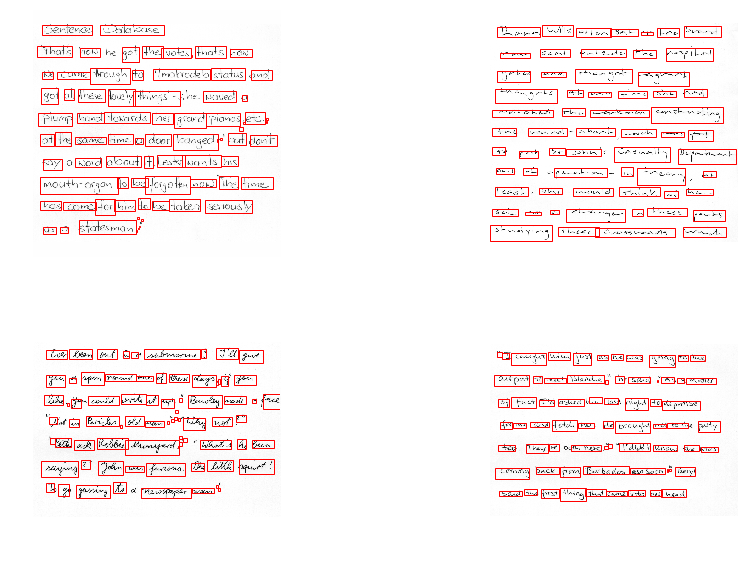

In [13]:
min_c = 0.001
overlap_thres = 0.001
topk = 350

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk)
    
    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')

    for j in range(predicted_bb.shape[0]):                
        (x, y, w, h) = expand_bounding_box(predicted_bb[j], expand_bb_scale_x=0.1,
                                           expand_bb_scale_y=0.02)
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

#### Word to line image processing
Algorithm to group all words within a line together.

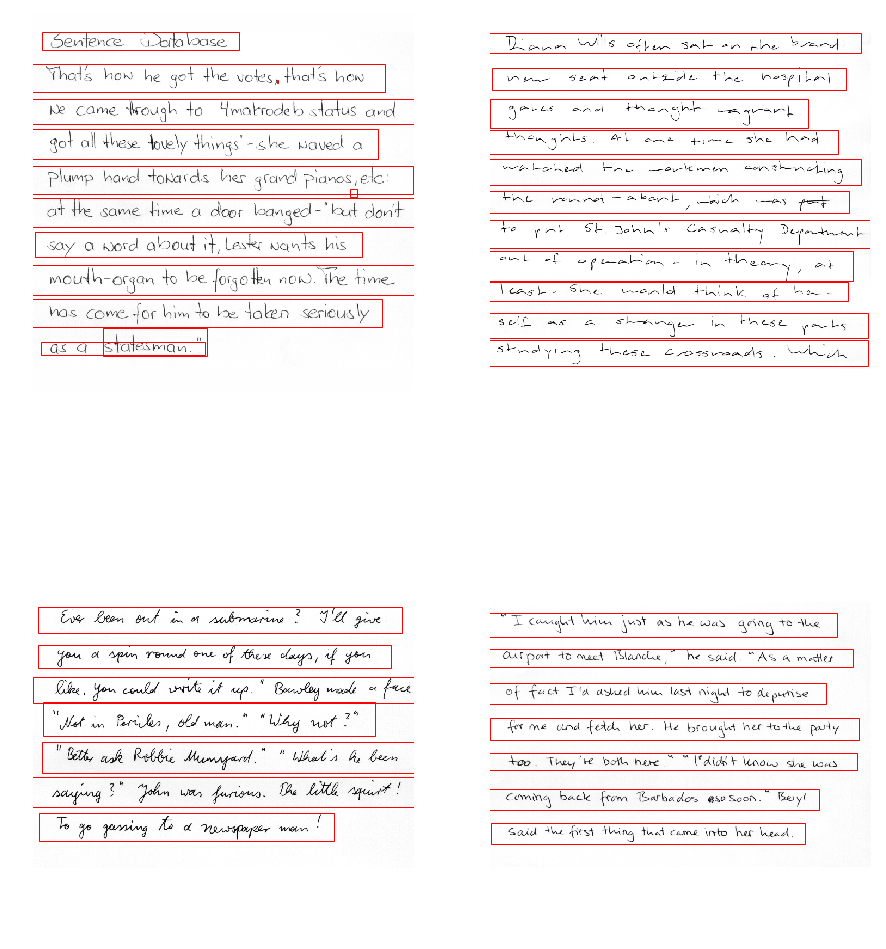

In [14]:
def clip_value(value, max_value):
    output = value
    if output < 0:
        output = 0
    if output > max_value:
        output = max_value
    return int(output)

def get_max_coord(bbs, x_or_y):
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    max_value = 0.0
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0] + bb[2]
        else:
            value = bb[1] + bb[3]
        if value > max_value:
            max_value = value
    return max_value

def get_min_coord(bbs, x_or_y):
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    min_value = 100
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0]
        else:
            value = bb[1]
        if value < min_value:
            min_value = value
    return min_value

def process_line(bbs_in_a_line, min_size=0.0005):
    # Remove bbs that are very small
    bbs = []
    for bb in bbs_in_a_line:
        if bb[2] * bb[3] > min_size:
            bbs.append(bb)

    bbs = bbs_in_a_line
    
    max_x = get_max_coord(bbs, x_or_y="x")
    min_x = get_min_coord(bbs, x_or_y="x")

    max_y = get_max_coord(bbs, x_or_y="y")
    min_y = get_min_coord(bbs, x_or_y="y")
            
    line_bb = (min_x, min_y, max_x - min_x, max_y - min_y)
    line_bb = expand_bounding_box(line_bb, expand_bb_scale_x=0.1,
                                          expand_bb_scale_y=0.1)

    return line_bb

def sort_bbs_line_by_line(bbs, line_cutoff=0.02):
    line_bbs = []
    bbs_in_a_line = []

    y_indexes = np.argsort(bbs[:, 1])
    previous_y_value = None
    for y_index in y_indexes:
        y_value = bbs[y_index, 1]
        
        if previous_y_value is not None and y_value - previous_y_value > line_cutoff: # A new line
            line_bb = process_line(bbs_in_a_line)
            #if line_bb == None:
            #    continue
            line_bbs.append(line_bb)
            bbs_in_a_line = []
        bbs_in_a_line.append(bbs[y_index, :])
        previous_y_value = y_value
    
    # process the last line
    line_bb = process_line(bbs_in_a_line)
    line_bbs.append(line_bb)
    return line_bbs

def crop_line_images(image, line_bbs):
    line_images = []
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        x1 = clip_value(x, max_value=image_w)
        x2 = clip_value(x + w, max_value=image_w)
        y1 = clip_value(y, max_value=image_h)
        y2 = clip_value(y + h, max_value=image_h)
        
        line_image = image[y1:y2, x1:x2]    
        line_images.append(line_image)
    line_images_array.append(line_images)
    return line_images

line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)


# Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [15]:
handwriting_line_recognition_net = HandwritingRecognitionNet(ctx=ctx)
handwriting_line_recognition_net.load_parameters("models/handwriting_line_recognition.params")

In [16]:
def handwriting_recognition_transform(image):
    image, _ = resize_image(image, line_image_size)
    image = mx.nd.array(image)/255.
    image = image.as_in_context(ctx)
    image = image.expand_dims(0).expand_dims(0)
    return image

bentence i btaloase
That's how he got the voles, that's how

Ne came through to Utmatrodeb status and
got all these towely things' s he waved a
plump hand towards her grand piomos, ete:

at the same time a door leanged -'but don't
say a word about it, Lester wants his
mouth-organ to be forgothn now. The time
has come for him to be taken seriously
statesman.&quot;
as a statesman.

Tiana hills often sat on the brand
re seat ontside the hotpital
gakes and thonght ragrant
thonghhs. at one time she had
uskched the -orkmen constncting
the ronnol -abont, which was pot
to put 5t. John 's casualty Dupantmant
ont of opeation - in theary, at
least. she would think of hea-
self as a stange in these parts
stndying these crossnoads, Whith

Ever been out in a submarine? Ill give
you a spin round one of therse days, if you
like. you could write it up.&quot; Buley made a frece
&quot;What in Pariles, old nean & ot;&Wthy not ?o
&quot;Water aste Robie sthengard& &q qWt;hetis he been
sayjing?uot; Johen was

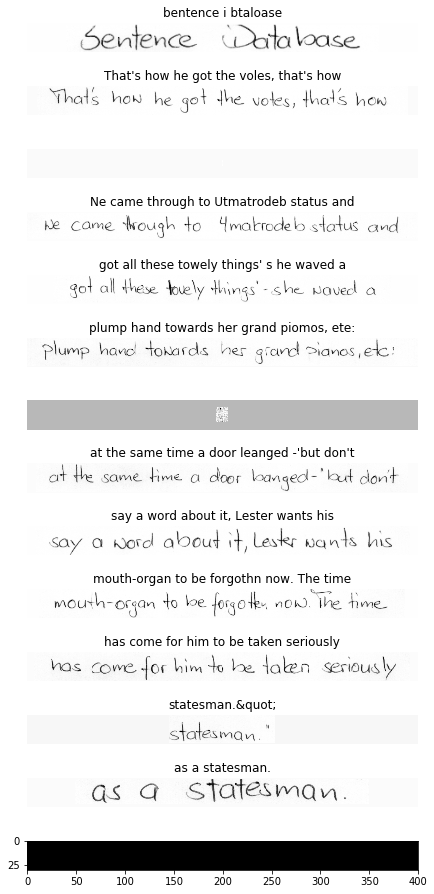

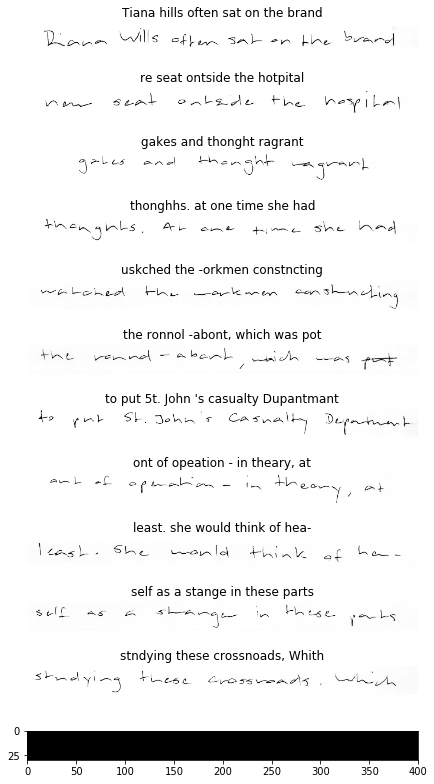

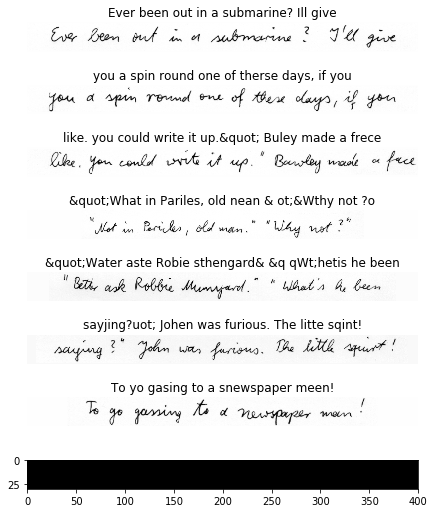

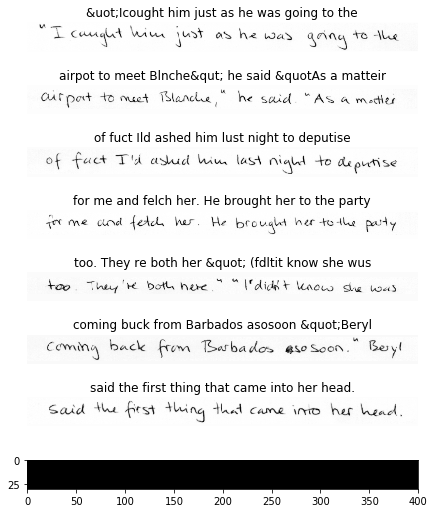

In [17]:
line_image_size = (30, 400)

for line_images in line_images_array:
    decoded_text_output = ""
    fig, axs = plt.subplots(len(line_images) + 1, figsize=(7, int(1 + 1.2 * len(line_images))))
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image)
        character_probabilities = handwriting_line_recognition_net(line_image)
        character_predictions = character_probabilities.softmax().topk(axis=2).asnumpy()
        decoded_text = decoder_handwriting(character_predictions)
        decoded_text_output += decoded_text[0] + "\n"

        axs[i].imshow(line_image.asnumpy().squeeze(), cmap='Greys_r')
        axs[i].set_title("{}".format(decoded_text[0]))
        axs[i].axis('off')
    print(decoded_text_output)
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    

# Quantitative Results

In [39]:
cer = []
for i in range(len(test_ds)):
    image, text = test_ds[i]
    resized_image = paragraph_segmentation_transform(image, image_size=(1120, 800))
    paragraph_bb = paragraph_segmentation_net(resized_image)
    paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb[0].asnumpy(), image_size=(700, 700))
    word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk)
    line_bbs = sort_bbs_line_by_line(word_bb)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    all_decoded_text = ""
    for line_image in line_images:
        line_image = handwriting_recognition_transform(line_image)
        character_probabilities = handwriting_line_recognition_net(line_image)
        character_predictions = character_probabilities.softmax().topk(axis=2).asnumpy()
        decoded_text = decoder_handwriting(character_predictions)
        all_decoded_text += decoded_text[0]
    dist = levenshtein(all_decoded_text, text[0])
    length = len(text[0])
    cer.append(dist/length)
    #print("{}\n\n\n{}\n\n{}/{} = {}".format(all_decoded_text, text[0], dist, length, dist/length))
print("Mean CER = {}%".format(np.mean(cer * 100)))

Mean CER = 0.23632527265172554
